In [10]:
# -*- coding:utf-8 -*-
import poloniex
import time
import json
from datetime import datetime

# poloniex API
polo = poloniex.Poloniex()
# 2018/02/19 09:00:00
unix_time = int(datetime.strptime("2018-2-18 15:00:00",'%Y-%m-%d %H:%M:%S').strftime('%s'))
print(unix_time)



#4h間隔で過去180日分 UNIX時間で取得  #14400
chart_data_btc = polo.returnChartData('USDT_BTC', period=polo.DAY, start=unix_time-polo.DAY*180, end=unix_time)
chart_data_eth = polo.returnChartData('USDT_ETH', period=1800, start=unix_time-polo.DAY*180, end=unix_time)


1519020000


In [1]:
# 
import requests
import json
from datetime import datetime

# 2017/12/31 AM 12:00 @JP
unix_time = datetime.strptime("2018-2-18 15:00:00",'%Y-%m-%d %H:%M:%S').strftime('%s')
print(unix_time)

q = {'periods':86400,'before':unix_time}
price = json.loads(requests.get('https://api.cryptowat.ch/markets/bitflyer/btcjpy/ohlc',params=q).text)['result']


1518933600


In [2]:
# crypto watch
import pandas as pd 
chart_data_btc = pd.DataFrame({'date':[p[0] for p in price['86400'][-180:]],
                          'close':[p[-3] for p in price['86400'][-180:]]
                         })
chart_data_btc.tail(10)

,close,date
170,896989,1518134400
171,953622,1518220800
172,940442,1518307200
173,887384,1518393600
174,972007,1518480000
175,924633,1518566400
176,1015216,1518652800
177,1074001,1518739200
178,1089298,1518825600
179,1187999,1518912000


In [74]:
# poloniex
import pandas as pd

# DataFrameに変換
df_btc = pd.DataFrame(chart_data_btc)
df_btc.tail(10)

# onedayで取得すると終わりが9時になる

,close,date,high,low,open,quoteVolume,volume,weightedAverage
170,8560.42138972,1518220800,9069.99999984,8144.47445801,8682.31340707,6157.8192782,53070135.402707,8618.33272544
171,8070,1518307200,8560.42138972,7805,8544.23896512,4509.32045465,36772320.677687,8154.73662772
172,8910,1518393600,9000,8070,8070,3826.23588267,33126284.390374,8657.66915741
173,8500.61835334,1518480000,8943.49999999,8355,8889.00000164,3642.31316735,31293751.677267,8591.72461
174,9469.99998292,1518566400,9485.88887924,8500.6183543,8523.09999763,4108.85804018,37263750.946118,9069.12591813
175,10004,1518652800,10198.5,9319.84000301,9456.2142096,5275.10959608,51604899.336311,9782.71605478
176,10161.00000514,1518739200,10279.99999999,9674.52416058,10010,3011.99598281,30062234.361222,9980.83481279
177,11049,1518825600,11069.43999976,10045,10161.00000514,3857.71800657,41193022.43693,10678.08024505
178,10379.00000001,1518912000,11248,10080,11049,4812.39715935,51229772.144017,10645.37494468
179,11155.99999985,1518998400,11246.98765432,10289.99999911,10399.99999946,3077.15666606,33452377.076487,10871.19724694


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
np.random.seed(1)

# 正規化
data_btc_ = pd.DataFrame([float(i) for i in chart_data_btc['close']])

mss = MinMaxScaler()
data_btc = pd.DataFrame(mss.fit_transform(data_btc_))

In [4]:
data_btc = np.array(data_btc.astype(np.float32))
data_btc_log = np.log(data_btc_)
data_btc_log = np.array(data_btc_log)

/Users/kyohei/.pyenv/versions/3.5.3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


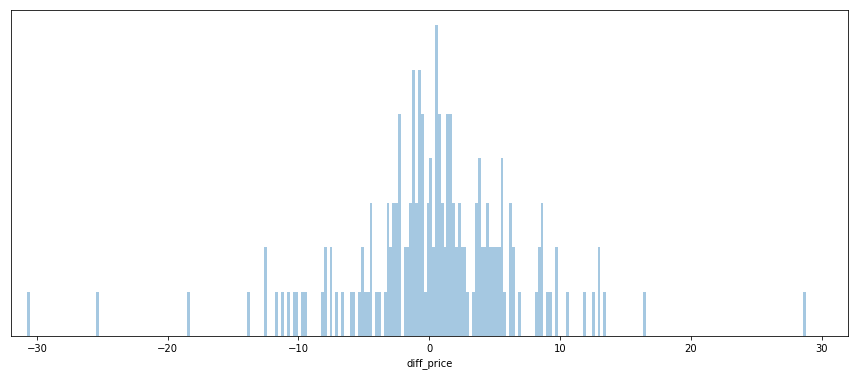

In [5]:
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6
import matplotlib.pyplot as plt


#前日との差
plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
diff_btc = data_btc_log[1:] - data_btc_log[:-1]
diff_btc *= 100
sns.distplot(diff_btc, bins=300, kde=False)
plt.tick_params(labelleft="off",left="off") # y軸の削除
plt.xlabel("diff_price")
plt.xlim(-32,32)
plt.show()


In [43]:
import matplotlib
matplotlib.matplotlib_fname()

'/Users/kyohei/.pyenv/versions/3.5.3/lib/python3.5/site-packages/matplotlib/mpl-data/matplotlibrc'

In [22]:
# 標準偏差
diff_std = np.std(diff_btc)
diff_avg = np.average(diff_btc)
print(diff_avg)

print("きょぴお")
print("標準偏差[%]:{:.2f}".format(np.exp(diff_std/100)*100))
print("標準偏差[%]:{:.2f}".format(diff_std))
print("平均[%]:{:.2f}".format(diff_avg))

0.5401261986416762
きょぴお
標準偏差[%]:107.33
標準偏差[%]:7.08
平均[%]:0.54


In [13]:
np.log(1.05)*100

4.879016416943205

In [78]:
# onehotラベル生成　
_t_btc = np.empty((len(data_btc),4),dtype=np.float64)
# とりあえず閾値は1sigma

#thresh = diff_std
thresh =  np.log(1.05)*100

# 棒グラフ用配列
bar_diff_btc = np.zeros(4)

for i in range(1,len(data_btc)):
    # めっちゃ上がる
    if diff_btc[i-1] >= thresh:  
        _t_btc[i] = np.array([1,0,0,0])
        bar_diff_btc[0] = bar_diff_btc[0] + 1
    # 上がる
    elif diff_btc[i-1] >= 0 and diff_btc[i-1] < thresh: 
        _t_btc[i] = np.array([0,1,0,0])
        bar_diff_btc[1] = bar_diff_btc[1] + 1
    # 下がる
    elif diff_btc[i-1] >= -thresh and  diff_btc[i-1] < 0: 
        _t_btc[i] = np.array([0,0,1,0])
        bar_diff_btc[2] = bar_diff_btc[2] + 1
    # めっちゃ下がる
    else : 
        _t_btc[i] = np.array([0,0,0,1])
        bar_diff_btc[3] = bar_diff_btc[3] + 1

/Users/kyohei/.pyenv/versions/3.5.3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


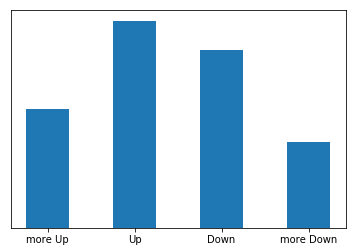

array([36., 63., 54., 26.])

In [79]:
rcParams['figure.figsize'] = 6, 4
left = np.array([1, 2, 3, 4])
label = ["more Up","Up","Down","more Down"]
plt.bar(left, bar_diff_btc, tick_label=label, align="center",width=0.5)
plt.tick_params(labelleft="off",left="off") # y軸の削除
plt.show()

bar_diff_btc

In [80]:
# データを入力変数xと出力変数tに切り分け
x_btc, t_btc= [], []

N = len(data_btc)
M = 30 # 入力変数の数：直近30サンプルを使用
for n in range(M, N):
 # 入力変数と出力変数の切り分け
 _x = data_btc[n-M: n] # 入力変数
 _t = _t_btc[n] # 出力変数
 # 計算用のリスト(x, t)に追加していく
 x_btc.append(_x)
 t_btc.append(_t)


In [81]:
# numpyに変換
# x.shape : 1050,30 t.shape : 1050,1
x_btc = np.array(x_btc)
t_btc = np.array(t_btc)

x_btc = x_btc.reshape(x_btc.shape[0], x_btc.shape[1], 1)
N_train = int(len(x_btc) * 0.9)
x_train, x_test = x_btc[:N_train], x_btc[N_train:]
t_train, t_test = t_btc[:N_train], t_btc[N_train:]

In [89]:
x_btc.shape

(150, 30, 1)

In [82]:
# model
# 4分類
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


length_of_sequence = x_btc.shape[1] # 30 = M
n_in = x_btc.shape[2]   # 学習データ（＝入力）の列数
print(t_btc.shape)
n_out = t_btc.shape[1]  # ラベルデータ（=出力）の列数

in_out_neurons = 1
# n_hidden: 出力次元
n_hidden = 30
model = Sequential()
# return_sequenceとは、TrueにしてRNNレイヤーの毎時刻の出力を得るか、Falseにして最後の時刻のみの出力を得るか、のフラグ
# batch_iuput_shape: ([バッチサイズ，step数，特徴の次元数])
model.add(LSTM(units=n_hidden,
               batch_input_shape=(None, length_of_sequence, n_in), 
               return_sequences=False
              ))
model.add(Dropout(0.5))
model.add(Dense(n_out))
model.add(Activation("softmax"))
optimizer = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]) # metrics = ['categorical_accuracy']

model.summary()


(150, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 30)                3840      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 124       
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0         
Total params: 3,964
Trainable params: 3,964
Non-trainable params: 0
_________________________________________________________________


In [84]:
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers import Input, Dense, Dropout, concatenate, LSTM, Embedding
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

length_of_sequence = x_btc.shape[1] # 30 = M
n_in = x_btc.shape[2]   # 学習データ（＝入力）の列数
n_out = t_btc.shape[1]  # ラベルデータ（=出力）の列数

in_out_neurons = 1
# n_hidden: 出力次元
n_hidden = 30

# LSTMモデル　作成(入力：価格)
# batch_iuput_shape: ([バッチサイズ，step数，特徴の次元数])
price_input = Input(shape=(length_of_sequence,n_in), name="price_input")
price_output = LSTM(units=n_hidden,batch_input_shape=(None, length_of_sequence, n_in), return_sequences=False)(price_input)
price_output = Dropout(0.5)(price_output)
price_output = Dense(n_out, activation="softmax")(price_output)
model = Model(input=price_input, output= price_output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) # metrics = ['categorical_accuracy']
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
price_input (InputLayer)     (None, 30, 1)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30)                3840      
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 124       
Total params: 3,964
Trainable params: 3,964
Non-trainable params: 0
_________________________________________________________________


/Users/kyohei/.pyenv/versions/3.5.3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("pr..., outputs=Tensor("de...)`


# ベクトル化したツイートを読み込み

In [83]:
tweet_vec = np.load("tweet_vec.npy")
# lstmが30日ずつなので
tweet_vec = tweet_vec[29:-1]

N_train = int(len(tweet_vec) * 0.9)
tweet_train, tweet_test = tweet_vec[:N_train], tweet_vec[N_train:]

In [120]:
tweet_train.shape

(135, 400)

# 2入力1出力モデル

In [91]:
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers import Input, Dense, Dropout, concatenate, LSTM, Embedding
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


length_of_sequence = x_btc.shape[1] # 30 = M
n_in = x_btc.shape[2]   # 学習データ（＝入力）の列数
n_out = t_btc.shape[1]  # ラベルデータ（=出力）の列数

in_out_neurons = 1
# n_hidden: 出力次元
n_hidden = 30

# LSTMモデル　作成(入力：価格)
price_input = Input(shape=(length_of_sequence, n_in), name="price_input")
price_output = LSTM(units=n_hidden,batch_input_shape=(None, length_of_sequence, n_in), return_sequences=False)(price_input)


# 全結合モデル作成 (入力：ツイッター)
twitter_input = Input(shape=(400,), dtype="float32", name="twitter_input")


# もう少し早く連結
x = concatenate([price_output, twitter_input])
main_output = Dense(512, activation='relu', name='main_output')(x)
main_output = Dropout(0.5)(main_output)
# 2つのモデルの出力を結合
#main_output = concatenate([price_output, twitter_output])

# 結合後の層
#main_output = Dense(512, activation="relu")(model_output)
main_output = Dense(n_out, activation="softmax")(main_output)

#model = Model(input=[price_input, twitter_input], output= [main_output, price_output, twitter_output])
model = Model(inputs=[price_input, twitter_input], outputs= [main_output])

#model.compile(loss="categorical_crossentropy", optimizer="adam", loss_weights=[1.0, 0.5, 0.3], metrics=["accuracy"])
model.compile(loss="categorical_crossentropy", optimizer="adam" ,metrics=["accuracy"])
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
price_input (InputLayer)         (None, 30, 1)         0                                            
____________________________________________________________________________________________________
lstm_12 (LSTM)                   (None, 30)            3840        price_input[0][0]                
____________________________________________________________________________________________________
twitter_input (InputLayer)       (None, 400)           0                                            
____________________________________________________________________________________________________
concatenate_9 (Concatenate)      (None, 430)           0           lstm_12[0][0]                    
                                                                   twitter_input[0][0]     

In [59]:
import os
import random as rn
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(8)
rn.seed(7)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

from keras import backend as K

tf.set_random_seed(7)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# 過去価格のみで予測

In [89]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

model.fit(x_train, t_train,
          batch_size=20,
          epochs=20,
          #validation_split=0.1,
          shuffle=True,
          callbacks=[early_stopping]
          )
model.save_weights('only_price_5per.h5')

Epoch 1/20
135/135 [==============================] - 0s - loss: 1.3070 - acc: 0.3556     
Epoch 2/20
 40/135 [=======>......................] - ETA: 0s - loss: 1.2850 - acc: 0.2500

/Users/kyohei/.pyenv/versions/3.5.3/lib/python3.5/site-packages/keras/callbacks.py:496: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


135/135 [==============================] - 0s - loss: 1.3003 - acc: 0.3852     
Epoch 3/20
135/135 [==============================] - 0s - loss: 1.2901 - acc: 0.3704     
Epoch 4/20
135/135 [==============================] - 0s - loss: 1.3068 - acc: 0.4074     
Epoch 5/20
135/135 [==============================] - 0s - loss: 1.3018 - acc: 0.3778     
Epoch 6/20
135/135 [==============================] - 0s - loss: 1.2833 - acc: 0.4074     
Epoch 7/20
135/135 [==============================] - 0s - loss: 1.2920 - acc: 0.4000     
Epoch 8/20
135/135 [==============================] - 0s - loss: 1.3121 - acc: 0.4000     
Epoch 9/20
135/135 [==============================] - 0s - loss: 1.2878 - acc: 0.3407     
Epoch 10/20
135/135 [==============================] - 0s - loss: 1.2698 - acc: 0.3407     
Epoch 11/20
135/135 [==============================] - 0s - loss: 1.2994 - acc: 0.3630     
Epoch 12/20
135/135 [==============================] - 0s - loss: 1.2996 - acc: 0.3556     
Epoch 1

# 過去価格＋ツイートで予測

In [96]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

model.fit([x_train,tweet_train], t_train,
          batch_size=20,
          epochs=20,
          shuffle=True,
          callbacks=[early_stopping]
          )
model.save_weights('price_tweet_5per.h5')

Epoch 1/20
135/135 [==============================] - 0s - loss: 1.2579 - acc: 0.4000     
Epoch 2/20
 40/135 [=======>......................] - ETA: 0s - loss: 1.3438 - acc: 0.3500

/Users/kyohei/.pyenv/versions/3.5.3/lib/python3.5/site-packages/keras/callbacks.py:496: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


135/135 [==============================] - 0s - loss: 1.2689 - acc: 0.4148     
Epoch 3/20
135/135 [==============================] - 0s - loss: 1.2689 - acc: 0.4000     
Epoch 4/20
135/135 [==============================] - 0s - loss: 1.2714 - acc: 0.4000     
Epoch 5/20
135/135 [==============================] - 0s - loss: 1.2698 - acc: 0.4074     
Epoch 6/20
135/135 [==============================] - 0s - loss: 1.2597 - acc: 0.4000     
Epoch 7/20
135/135 [==============================] - 0s - loss: 1.2592 - acc: 0.4000     
Epoch 8/20
135/135 [==============================] - 0s - loss: 1.2674 - acc: 0.4000     
Epoch 9/20
135/135 [==============================] - 0s - loss: 1.2619 - acc: 0.3926     
Epoch 10/20
135/135 [==============================] - 0s - loss: 1.2551 - acc: 0.4074     
Epoch 11/20
135/135 [==============================] - 0s - loss: 1.2729 - acc: 0.3926     
Epoch 12/20
135/135 [==============================] - 0s - loss: 1.2659 - acc: 0.4000     
Epoch 1

In [17]:
model.load_weights('price_tweet_007_067.h5')

In [97]:
# 正答率、準正答率（騰落）集計
preds = model.predict([x_test,tweet_test])
correct = 0
semi_correct = 0
for i in range(len(preds)):
  pred = np.argmax(preds[i,:])
  tar = np.argmax(t_test[i,:])
  if pred == tar :
    # 純粋な正解率
    correct += 1
  else :
    # 上下は当たってるやつ
    if pred+tar == 1 or pred+tar == 5 : 
      semi_correct += 1

print("正答率:{:.2f}".format(1.0 * correct / len(preds)))
print("単純正答率:{:.2f}".format(1.0 * (correct+semi_correct) / len(preds)))


正答率:0.13
単純正答率:0.60
